In [98]:
import pandas as pd
import json
import time
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for the progress bar
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, classification_report
import seaborn as sns
import numpy as np
import sklearn

In [99]:
from confidenceinterval import classification_report_with_ci
from confidenceinterval.bootstrap import bootstrap_ci


# Evaluate Multi-Class


## Load individual file with predictions

Skip the below if you have already loaded multiple files!

In [100]:
prompt_ids_to_eval = ["P2", "P3"] # ["P6", "P7", "P11_3", "P11_4"]
model = "gpt-3.5-turbo" #"gpt-3.5-turbo" "gpt-4-turbo-preview"
data_type = "enriched_kw" # change when evaluating enriched without kw/ not enriched to be able to load and save the correct names

In [101]:
# Create the list of prediction columns based on the prompt IDs
prediction_columns = [f'gpt_predictions_{prompt_id}' for prompt_id in prompt_ids_to_eval]
# Specify the basic columns to include in the DataFrame
basic_columns = ['pmid', 'accepted_label', 'multi_label', 'binary_label']
# Combine basic columns with the dynamically generated prediction columns
columns_to_read = basic_columns + prediction_columns

df_binary = pd.read_csv(f"predictions/{model}_{data_type}_test_outputs_{'_'.join(prompt_ids_to_eval)}_binary.csv")[columns_to_read]

In [102]:
columns_to_read

['pmid', 'accepted_label', 'multi_label', 'binary_label', 'gpt_predictions_P3']

In [103]:
df_binary.shape

(534, 5)

In [104]:
df_binary.head()

,pmid,accepted_label,multi_label,binary_label,gpt_predictions_P3
0,12047012,Non-systematic-review,1,0,OTHER
1,28832188,Non-systematic-review,1,0,OTHER
2,17678496,Non-systematic-review,1,0,OTHER
3,25649308,Non-systematic-review,1,0,OTHER
4,6312596,Non-systematic-review,1,0,OTHER


## Map predictions to numerical

In [105]:
label_to_numerical = {
    'Remaining': 0,
    'Non-systematic-review': 1,
    'Human-non-RCT-non-drug-intervention': 2,
    'Human-non-RCT-drug-intervention': 3,
    'Human-case-report': 4,
    'Animal-other': 5,
    'Animal-drug-intervention': 6,
    'Human-systematic-review': 7,
    'In-vitro-study': 8,
    'Human-RCT-non-drug-intervention': 9,
    'Animal-non-drug-intervention': 10,
    'Human-RCT-drug-intervention': 11,
    'Clinical-study-protocol': 12,
    'Human-RCT-non-intervention': 13
}

In [106]:
numerical_to_label = {v: f"{v} - {k}" for k, v in label_to_numerical.items()}

In [107]:
import difflib
def map_label_fuzzy(label, label_dict):
    #label = label.lower().replace('-', '').replace('_', ' ').strip()
    best_match = difflib.get_close_matches(label, label_dict.keys(), n=1, cutoff=0.6)
    if best_match:
        #print(f'{label} matched to {best_match[0]}')
        return label_dict[best_match[0]]
    return -1

In [108]:
map_label_fuzzy("RCT-drug-intervention", label_to_numerical)

11

In [109]:
def map_label_to_numerical(label, label_dict):
    # Check if label is a dictionary
    if isinstance(label, dict):
        print(label)
        # Extract the label with the highest score/probability
        highest_label = max(normalized_label, key=label.get)
        return label_dict.get(highest_label, -1)
    else:
         # Normalize label
        normalized_label = label.replace(',', '').strip().replace(' ', '-')#.strip()
        # Directly map string labels to numerical IDs
        numerical_label = label_dict.get(label, -1)
        # Fuzzy match if no direct mapping possible
        if numerical_label == -1:
            numerical_label = map_label_fuzzy(normalized_label, label_dict)
        # If fuzzy match did not work, check if the label string contains the key 'label' and use it to split the string; keep everything to the right as the potential label
        if numerical_label == -1:
            if 'label' in label:
                label_part = label.split('label')[1]
                numerical_label = map_label_fuzzy(label_part, label_dict)
        return numerical_label
        
# Convert accepted labels to numerical
#df['accepted_label_numerical'] = df['accepted_label'].apply(lambda x: map_label_to_numerical(x, label_to_numerical))


#for col in prediction_columns:
    df[f'{col}_numerical'] = df[col].apply(lambda x: map_label_to_numerical(x, label_to_numerical))

df.head()

,pmid,accepted_label,multi_label,binary_label,gpt_predictions_P1
0,12047012,Non-systematic-review,1,0,OTHER
1,28832188,Non-systematic-review,1,0,OTHER
2,17678496,Non-systematic-review,1,0,OTHER
3,25649308,Non-systematic-review,1,0,OTHER
4,6312596,Non-systematic-review,1,0,OTHER


In [110]:
def is_list_of_lists(lst):
    return all(isinstance(sublist, list) for sublist in lst)

if is_list_of_lists(prompt_ids_to_eval):
    # Flatten the list of lists
    prompt_ids_to_eval_flat = [item for sublist in prompt_ids_to_eval for item in sublist]
    # Create a string suffix for the CSV file name
    csv_file_suffix = '_'.join(prompt_ids_to_eval_flat)
else:
    csv_file_suffix = '_'.join(prompt_ids_to_eval)

In [111]:
df_binary.to_csv(f"predictions/{model}_{data_type}_test_outputs_{'_'.join(csv_file_suffix)}_binary_structured.csv")

#### Important: some labels from GPT could not be mapped to a target label

In [112]:
#rows_with_minus_one = df[(df == -1).any(axis=1)]
#rows_with_minus_one

## Evaluate prompts

In [113]:
def evaluate_predictions_with_ci(df, target_label_col, prompt_ids_to_eval, model, eval_type, label_to_numerical, numerical_to_label, csv_file_suffix=None, digits=3):
    report_dfs = []
    summary_stats = []

    for prompt_id in prompt_ids_to_eval:
        print("Evaluating ", prompt_id)
        prediction_col = f'gpt_predictions_{prompt_id}'

        # Extract arrays for evaluation
        y_true = df[target_label_col].values
        y_pred = df[f'{prediction_col}_numerical'].values
        cm = confusion_matrix(y_true, y_pred, labels=range(len(label_to_numerical)))
        
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        accuracy_balanced = balanced_accuracy_score(y_true, y_pred)
        report = classification_report_with_ci(y_true, y_pred, numerical_to_label_map=numerical_to_label, round_ndigits = digits)
        #from old notebook: report = classification_report(y_true, y_pred, output_dict=True, zero_division=0, labels=range(len(label_to_numerical)), target_names=[numerical_to_label[i] for i in range(len(label_to_numerical))])
        
        # Create DataFrame from report
        report_df = pd.DataFrame(report)
        report_df['Prompt ID'] = prompt_id
        report_dfs.append(report_df)
        
        # Extract summary statistics
        report_df.set_index('class', inplace=True)
        summary = report_df.loc['weighted avg', ['precision', 'precision CI', 'recall', 'recall CI', 'f1-score', 'f1-score CI', 'accuracy', 'accuracy CI']].to_dict()
        summary['Prompt ID'] = prompt_id
        summary_stats.append(summary)

        # Plotting confusion matrix
        plt.figure(figsize=(10, 6))
        ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(len(label_to_numerical)), yticklabels=range(len(label_to_numerical)))
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=13)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=13)
        plt.title(f'Confusion Matrix for Model {model} and Prompt {prompt_id}', fontsize=14)
        plt.xlabel('Predicted Labels', fontsize=13)
        plt.ylabel('True Labels', fontsize=13)

        # Add an inset with label mapping
        textstr = '\n'.join([f'{v}: {k}' for k, v in label_to_numerical.items()])
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(1.16, 1.0, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=props)
        plt.tight_layout()
        plt.savefig(f'plots/confusion_matrix_{model}_{data_type}_{prompt_id}_{eval_type}_with_ci.pdf')  # Save to PDF

    # Combine all report DataFrames
    all_reports_df = pd.concat(report_dfs)

    # Create a summary table for average precision, recall, and F1-score
    summary_df = pd.DataFrame(summary_stats)

    if not csv_file_suffix:
        csv_file_suffix = '_'.join(prompt_ids_to_eval) + "_" + eval_type
    
    # Save results to CSV files
    all_reports_df.to_csv(f"evaluations/{model}_{data_type}_test_per_class_{csv_file_suffix}_{eval_type}_with_ci.csv")
    summary_df.to_csv(f"evaluations/{model}_{data_type}_test_summary_{csv_file_suffix}_{eval_type}_with_ci.csv")
    
    print("Results saved to evaluations/ and plots/ folders.")

    return all_reports_df, summary_df


## Map to numerical

In [114]:
label_to_numerical_binary= {
    'OTHER': 0,
    'ANIMAL': 1,
}
numerical_to_label_binary = {v: f"{v} - {k}" for k, v in label_to_numerical_binary.items()}


In [115]:
for col in prediction_columns:
    df_binary[f'{col}_numerical'] = df_binary[col].apply(lambda x: map_label_to_numerical(x, label_to_numerical_binary))

In [116]:
df_binary.head()

,pmid,accepted_label,multi_label,binary_label,gpt_predictions_P3,gpt_predictions_P3_numerical
0,12047012,Non-systematic-review,1,0,OTHER,0
1,28832188,Non-systematic-review,1,0,OTHER,0
2,17678496,Non-systematic-review,1,0,OTHER,0
3,25649308,Non-systematic-review,1,0,OTHER,0
4,6312596,Non-systematic-review,1,0,OTHER,0


In [117]:
rows_with_minus_one = df_binary[(df_binary == -1).any(axis=1)]
rows_with_minus_one

,pmid,accepted_label,multi_label,binary_label,gpt_predictions_P3,gpt_predictions_P3_numerical


## Evaluate

In [118]:
csv_file_suffix

'P3'

In [119]:
prompt_ids_to_eval

['P3']

Evaluating  P3
Results saved to evaluations/ and plots/ folders.


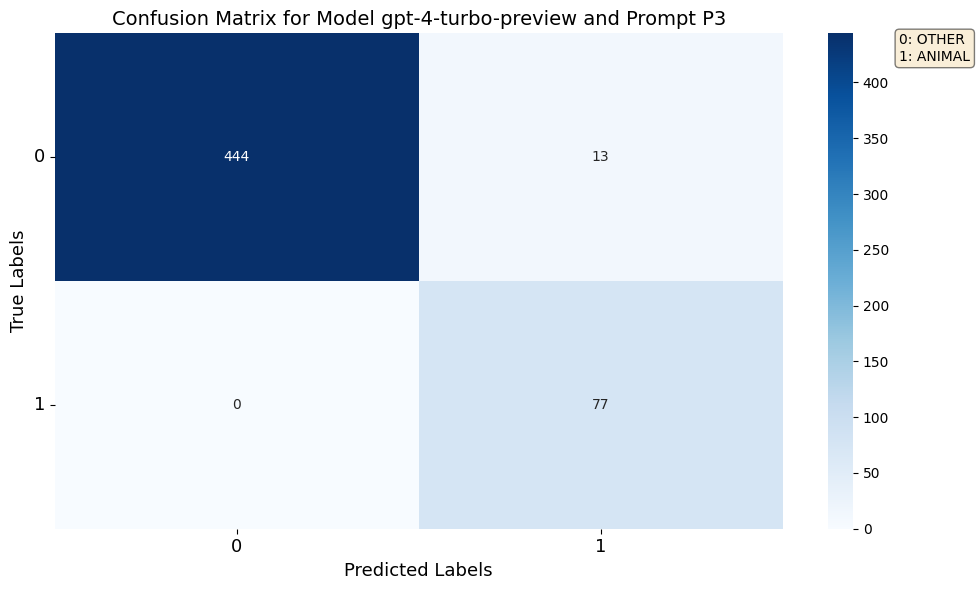

In [120]:
target_label_col = 'binary_label'
eval_type = 'binary_label'
all_reports_df, summary_df = evaluate_predictions_with_ci(df_binary, target_label_col, prompt_ids_to_eval, model, eval_type, label_to_numerical_binary, numerical_to_label_binary, csv_file_suffix)


In [121]:
summary_df

,precision,precision CI,recall,recall CI,f1-score,f1-score CI,accuracy,accuracy CI,Prompt ID
0,0.979,"(0.968, 0.988)",0.976,"(0.961, 0.987)",0.976,"(0.962, 0.987)",0.976,"(0.961, 0.987)",P3


In [122]:
all_reports_df

,precision,recall,f1-score,accuracy,precision CI,recall CI,f1-score CI,accuracy CI,support,Prompt ID
class,,,,,,,,,,
0 - OTHER,1.000,0.972,0.986,0.976,"(0.991, 1.0)","(0.952, 0.983)","(0.973, 0.998)","(0.959, 0.986)",457,P3
1 - ANIMAL,0.856,1.000,0.922,0.976,"(0.768, 0.914)","(0.952, 1.0)","(0.876, 0.968)","(0.959, 0.986)",77,P3
micro,0.976,0.976,0.976,NaN,"(0.963, 0.989)","(0.963, 0.989)","(0.963, 0.989)",NaN,534,P3
macro,0.928,0.986,0.954,NaN,"(0.894, 0.961)","(0.968, 1.004)","(0.892, 1.016)",NaN,534,P3
weighted avg,0.979,0.976,0.976,0.976,"(0.968, 0.988)","(0.961, 0.987)","(0.962, 0.987)","(0.961, 0.987)",534,P3
accuracy,0.976,0.976,0.976,0.976,"(0.961, 0.987)","(0.961, 0.987)","(0.961, 0.987)","(0.961, 0.987)",534,P3


## Format Results and Generate LateX

In [93]:
# Case of combining separately evaluated prompt files

model = "gpt-3.5-turbo"

prompt_ids_to_eval = ["P1"]
summary_gpt3_raw_1 = pd.read_csv(f"evaluations/{model}_{data_type}_test_summary_{'_'.join(prompt_ids_to_eval)}_{eval_type}_with_ci.csv", index_col=0)

prompt_ids_to_eval = ["P2", "P3"]
summary_gpt3_raw_2 = pd.read_csv(f"evaluations/{model}_{data_type}_test_summary_{'_'.join(prompt_ids_to_eval)}_{eval_type}_with_ci.csv", index_col=0)

summary_gpt3_raw = pd.concat([summary_gpt3_raw_1,summary_gpt3_raw_2]) 
summary_gpt3_raw

,precision,precision CI,recall,recall CI,f1-score,f1-score CI,accuracy,accuracy CI,Prompt ID
0,0.918,"(0.888, 0.94)",0.921,"(0.897, 0.942)",0.914,"(0.884, 0.938)",0.921,"(0.897, 0.942)",P1
0,0.912,"(0.883, 0.935)",0.916,"(0.89, 0.936)",0.906,"(0.875, 0.932)",0.916,"(0.89, 0.936)",P2
1,0.948,"(0.927, 0.964)",0.946,"(0.923, 0.963)",0.947,"(0.925, 0.963)",0.946,"(0.923, 0.963)",P3


In [94]:
map_prompt_to_concept = {
    'P1': 'zero-shot',
    'P2': 'zero-shot',
    'P3': 'zero-shot'
}

In [95]:
# Custom sorting function
def custom_sort(prompt):
    import re
    # Extract numbers from the prompt
    numbers = re.findall(r'\d+', prompt)
    if numbers:
        # Primary sort by the first number, secondary sort by the full string
        return (int(numbers[0]), prompt)
    return (float('inf'), prompt)  # Handles cases without numbers
    
def format_summary_for_latex_report(summary_df, map_prompt_to_concept):
    summary_df = summary_df.copy()
    
    # Concatenating each metric with its CI
    summary_df['Precision (CI)'] = summary_df['precision'].astype(str) + ' ' + summary_df['precision CI'].astype(str)
    summary_df['Recall (CI)'] = summary_df['recall'].astype(str) + ' ' + summary_df['recall CI'].astype(str)
    summary_df['F1-Score (CI)'] = summary_df['f1-score'].astype(str) + ' ' + summary_df['f1-score CI'].astype(str)
    summary_df['Accuracy (CI)'] = summary_df['accuracy'].astype(str) + ' ' + summary_df['accuracy CI'].astype(str)
    
    # Dropping old columns
    summary_df.drop(columns=['precision', 'precision CI', 'recall', 'recall CI', 'f1-score', 'f1-score CI', 'accuracy', 'accuracy CI'], inplace=True)
    
    # Rename 'Prompt ID' to 'Prompt'
    summary_df.rename(columns={'Prompt ID': 'Prompt'}, inplace=True)
    
    # Apply the mapping
    summary_df['Concept'] = summary_df['Prompt'].map(map_prompt_to_concept)
    
    # Rearrange the columns to put 'Concept' after 'Prompt'
    summary_df = summary_df[['Prompt', 'Concept', 'Precision (CI)', 'Recall (CI)', 'F1-Score (CI)', 'Accuracy (CI)']]

    summary_df['sort_key'] = summary_df['Prompt'].apply(custom_sort)
    summary_df.sort_values('sort_key', inplace=True)
    summary_df.drop('sort_key', inplace=True, axis=1)
    
    return summary_df
    

In [96]:
summary_gpt3 = format_summary_for_latex_report(summary_gpt3_raw, map_prompt_to_concept)
summary_gpt3['Model'] = 'gpt-3.5'
summary_gpt3 = summary_gpt3.dropna(subset=['Concept'])
summary_gpt3

,Prompt,Concept,Precision (CI),Recall (CI),F1-Score (CI),Accuracy (CI),Model
0,P1,zero-shot,"0.918 (0.888, 0.94)","0.921 (0.897, 0.942)","0.914 (0.884, 0.938)","0.921 (0.897, 0.942)",gpt-3.5
0,P2,zero-shot,"0.912 (0.883, 0.935)","0.916 (0.89, 0.936)","0.906 (0.875, 0.932)","0.916 (0.89, 0.936)",gpt-3.5
1,P3,zero-shot,"0.948 (0.927, 0.964)","0.946 (0.923, 0.963)","0.947 (0.925, 0.963)","0.946 (0.923, 0.963)",gpt-3.5


In [97]:
summary_gpt3.drop(columns=['Model', 'Accuracy (CI)'], inplace=True)

print(summary_gpt3.to_latex(float_format="%.3f", index=False, formatters={'Prompt': lambda x: x.replace('_', r'\_')}))

\begin{tabular}{lllll}
\toprule
Prompt & Concept & Precision (CI) & Recall (CI) & F1-Score (CI) \\
\midrule
P1 & zero-shot & 0.918 (0.888, 0.94) & 0.921 (0.897, 0.942) & 0.914 (0.884, 0.938) \\
P2 & zero-shot & 0.912 (0.883, 0.935) & 0.916 (0.89, 0.936) & 0.906 (0.875, 0.932) \\
P3 & zero-shot & 0.948 (0.927, 0.964) & 0.946 (0.923, 0.963) & 0.947 (0.925, 0.963) \\
\bottomrule
\end{tabular}

